# 0. 準備

In [12]:
import scipy 
from scipy.linalg import solve_triangular
from scipy.linalg.lapack import dpotrf, dtrtri, dpotrs, dpotri
import numpy as np
import pandas as pd

import sys
sys.path.append('../')
from linalg_util import *

from gp_util import *

In [13]:
import gp_util
import importlib
importlib.reload(gp_util)

<module 'gp_util' from '/home/onoue/ws/SGPR/experiments/../gp_util.py'>

In [14]:
X, Y, X_pred = make_data()
noise = 1.
k = RBF()
K = k.K(X)
Ky = K.copy() + np.eye(K.shape[0]) * (noise+1e-8)
LW = customized_cholesky(Ky)
alpha = solve_triangular(LW.T, solve_triangular(LW, Y, lower=True))

# 1. Posterior クラス 動作確認

In [15]:
posterior = Posterior(woodbury_chol=LW, woodbury_vector=alpha, K=K)

In [16]:
pd.DataFrame(posterior.woodbury_inv).head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,0.5,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
1,0.0,0.5,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
2,0.0,0.0,5.000000e-01,-3.459741e-88,2.393962e-175,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
3,0.0,0.0,-3.459741e-88,5.000000e-01,-3.459741e-88,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0
4,0.0,0.0,2.393962e-175,-3.459741e-88,5.000000e-01,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0


((50, 1), (50, 1), (50, 50))

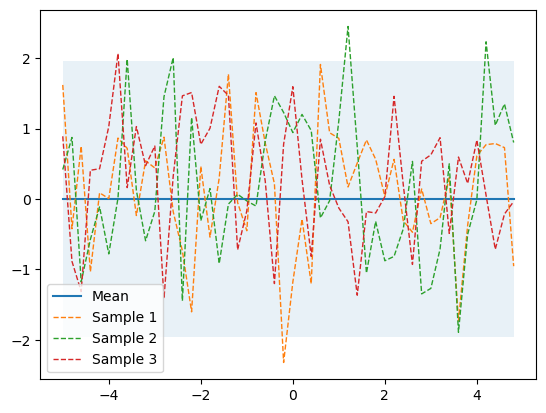

In [18]:
import matplotlib.pyplot as plt

def plot_gp(X, mu, cov, X_train=None, Y_train=None):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()


# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = k.K(X)

# Draw three samples from the prior
samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# Plot GP mean, uncertainty region and samples 
plot_gp(mu, cov, X, samples=samples)

X.shape, mu.shape, cov.shape

In [19]:
from numpy.linalg import inv

def posterior(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    """
    Computes the suffifient statistics of the posterior distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    """
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (7)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (8)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

In [20]:
# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior distribution
mu_s, cov_s = posterior(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

NameError: name 'kernel' is not defined